In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
import pandas as pd
import os
from cvlib.object_detection import draw_bbox
import datetime
from ipywidgets import *

Using TensorFlow backend.


In [52]:
class ImageFile(object):
    """A file that is a picture of droplets

    Attributes:
        path: The location of the file
        name: the file name
    """

    def __init__(self, path, name):
        """Returns an ImageFile object"""
        self.path = path
        self.name = name
        self.list_of_droplets = []
        self.creation_time = datetime.datetime.now().isoformat()
        self.list_of_droplets = []
        self.contains_droplets = None

    def __repr__(self):
        return "ImageFile()"

    def __str__(self):
        return str(vars(self))

    def find_droplets(self, method='HOUGH'):
        """Find the position of droplets
        defaulting to the HoughCircles method from OpenCV2
        """
        param1 = 80
        param2 = 20
        minRadius = 5
        maxRadius = 50
        # The zero means that it will load in grayscale only
        file_to_open = '{0}/{1}'.format(self.path, self.name)
        # print(file_to_open)
        in_img = cv2.imread(file_to_open)

        in_img_gray = cv2.cvtColor(
            in_img, cv2.COLOR_BGR2GRAY)  # grayscale concversion
        try:
            circles = cv2.HoughCircles(in_img_gray,
                                       cv2.HOUGH_GRADIENT,
                                       1,
                                       120,
                                       param1=param1,
                                       param2=param2,
                                       minRadius=minRadius,
                                       maxRadius=maxRadius)
            circles = np.uint16(np.around(circles))
            self.contains_droplets = True
            
            x_positions = circles[0, :, 0]
            y_positions = circles[0, :, 1]
            radii = circles[0, :, 2]

            cut_from = in_img.copy()

            for circle_index, value in enumerate(x_positions):
                x_pos = x_positions[circle_index]
                y_pos = y_positions[circle_index]
                radius = radii[circle_index]
                if circle_index > -1:
                    # image_i=cut_from[x_pos:radius,y_pos:radius]
                    image_i = cut_from[y_pos-radius*3:y_pos +
                                       radius*3, x_pos-radius*3:x_pos+radius*3]

                    droplet = DropletImage(
                        original_image_path=self.path,
                        original_image_name=self.path,
                        path=self.path+'/Cuts',
                        image=image_i,
                        id_number=circle_index,
                        position=(x_pos, y_pos),
                        radius=radius, drop_type=None)
                    self.list_of_droplets.append(droplet)


        except Exception as e:
            ###print(e)  #release check this
            self.contains_droplets = False
            

class DropletImage(object):
    """An image of a single droplet
    Attributes:
        original_image: the original image the droplet is from (path+name)
        path: the path to the  droplet image
        id_number: the id of the droplet
        position: the position of the droplet in the original image
        radius: the radius of the droplet
        type: the type of droplet
    """

    def __init__(self, original_image_path=None, original_image_name=None, path=None,
                 image=None, id_number=None, position=(None, None), radius=None, drop_type=None):
        """Returns an DropletImage object"""
        self.original_image_path = original_image_path
        self.original_image_name = original_image_name
        if path == None:
            self.path = self.original_image_path
        else:
            self.path = path
        self.image = image  # open cv object
        self.id_number = id_number
        self.position = position
        self.radius = radius
        self.drop_type = drop_type
        self.creation_time = datetime.datetime.now().isoformat()
        self.gen_descriptor()

    def __repr__(self):
        return "DropletImage()"

    def __str__(self):
        return str(vars(self))

#    def set_position(self, position=(None, None)):
#        """Set the position of the droplet in the original image"""
#        self.position = position

    def show_droplet(self):
        plt.imshow(self.image)  # openCV object

    def save_image(self, extra=''):
        if self.desc_string == None:
            self.gen_descriptor()
        try:
            cv2.imwrite('{0}/{6}_{1}_x_{2}y_{3}r_{4}_cut{5}.png'.format(
                self.path,
                self.id_number,
                self.position[0],
                self.position[1],
                self.radius,
                self.id_number, extra),
                self.image)
        except:
            print('something went wrong with saving {0}/{6}_{1}_x_{2}y_{3}r_{4}_cut{5}.png'.format(
                self.path,
                self.id_number,
                self.position[0],
                self.position[1],
                self.radius,
                self.id_number, extra))
            if self.position[0]-self.radius*2 < 0:
                print('Droplet too close to edge')
        else:
            cv2.imwrite('{0}/{6}_{1}_x_{2}y_{3}r_{4}_cut{5}.png'.format(
                self.path,
                self.id_number,
                self.position[0],
                self.position[1],
                self.radius,
                self.id_number, extra),
                self.image)

    def set_path(self, input_path):
        self.path = input_path

    def gen_descriptor(self, desc_type=None):
        if desc_type == None:
            desc_string = '\t'.join(
                [self.creation_time, str(self.id_number), str(self.position), str(self.radius), str(self.drop_type)])
            header_string_1 = 'Droplets from {0}{1}\n'.format(
                self.original_image_path, self.original_image_name, self.creation_time)
            header_string_2 = '\t'.join(
                ['Date', 'ID', 'Position (x,y)', 'Radius', 'Type'])
            self.header_string = header_string_1+header_string_2
            self.desc_string = desc_string
            return desc_string
        elif desc_type == 'Full':
            desc_string = '\t'.join(
                [self.original_image_path, self.original_image_name, self.creation_time, str(self.id_number), str(self.position), str(self.radius), str(self.drop_type)])
            header_string = '\t'.join(
                ['Parent_file', 'Date', 'ID', 'Position (x,y)', 'Radius', 'Type'])
            self.header_string = header_string
            self.desc_string = desc_string
            return desc_string
        else:
            return self.id

In [53]:
test_image_1 = ImageFile(
    '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images',
    '1.5mm_53.6ul_254.5kHz.png')

print(test_image_1)

test_droplet1 = DropletImage(test_image_1.path, test_image_1.name)

print(test_droplet1)

text = test_droplet1.gen_descriptor()
print(text)

{'path': '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images', 'name': '1.5mm_53.6ul_254.5kHz.png', 'list_of_droplets': [], 'creation_time': '2020-03-03T11:34:15.696394', 'contains_droplets': None}
{'original_image_path': '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images', 'original_image_name': '1.5mm_53.6ul_254.5kHz.png', 'path': '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images', 'image': None, 'id_number': None, 'position': (None, None), 'radius': None, 'drop_type': None, 'creation_time': '2020-03-03T11:34:15.696614', 'header_string': 'Droplets from /Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images1.5mm_53.6ul_254.5kHz.png\nDate\tID\tPosition (x,y)\tRadius\tType', 'desc_string': '2020-03-03T11:34:15.696614\tNone\t(None, None)\tNone\tNone'}
2020-03-03T11:34:15.696614	None	(None, None)	None	None


/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	2020-03-03T11:34:16.611217	0	(952, 450)	29	None
/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	2020-03-03T11:34:16.611294	1	(1192, 948)	29	None
/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	2020-03-03T11:34:16.611343	2	(1828, 710)	32	None


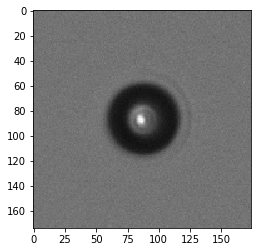

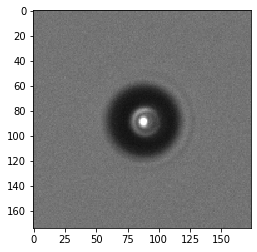

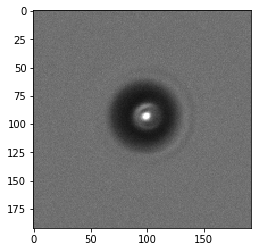

In [54]:
cwd = os.getcwd()
path_to_create = '/'.join([cwd, 'Results'])
os.makedirs(path_to_create, exist_ok=True)

test_image_2 = ImageFile(
    '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images',
    '26.5mm_53.6ul_254.5kHz-02122020182515-19.png')
test_image_2.find_droplets()

for i in test_image_2.list_of_droplets:
    plt.figure()
    plt.imshow(i.image)
    i.gen_descriptor('Full')
    print(i.desc_string)

In [55]:
current_path = cwd = os.getcwd()
path_to_files = '/'.join([current_path, '41.5mm_53.6ul_254.5kHz_1200frames'])

list_of_files = os.listdir(path_to_files)
print('found {0} files'.format(str(len(list_of_files))))
list_of_files.sort()
print('sorted')

list_of_files_to_do = list_of_files.copy()[0:100]

'''list_of_files = ['41.5mm_53.6ul_254.5kHz-02122020183727-1.png',
                 '41.5mm_53.6ul_254.5kHz-02122020183728-5.png',
                 '41.5mm_53.6ul_254.5kHz-02122020183728-6.png',
                 '41.5mm_53.6ul_254.5kHz-02122020184608-138.png',
                 '41.5mm_53.6ul_254.5kHz-02122020184726-413.png',
                 '41.5mm_53.6ul_254.5kHz-02122020184824-620.png',
                 '41.5mm_53.6ul_254.5kHz-02122020184908-795.png',
                 '41.5mm_53.6ul_254.5kHz-02122020184930-878.png',
                 '41.5mm_53.6ul_254.5kHz-02122020184942-924.png',
                 '41.5mm_53.6ul_254.5kHz-02122020184958-990.png']
'''
list_of_image_files = []

for file_index, file_name in enumerate(list_of_files_to_do):
    # print(file_name)
    temp_file = ImageFile(path_to_files, file_name)
    list_of_image_files.append(temp_file)
    temp_file.find_droplets()

    if temp_file.contains_droplets:
        print(file_name)
        for i in temp_file.list_of_droplets:
            i.gen_descriptor('Full')
            i.set_path(current_path + "/Results")
            # print(i.desc_string)
            i.save_image(extra=temp_file.name)

            # print(i.desc_string)
    else:
        print('No droplets in {0}'.format(file_name))

found 1200 files
sorted
41.5mm_53.6ul_254.5kHz-02122020183726-0.png
something went wrong with saving /Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Results/41.5mm_53.6ul_254.5kHz-02122020183726-0.png_0_x_16y_1090r_31_cut0.png
Droplet too close to edge
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183727-1.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183727-2.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183727-3.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183727-4.png
41.5mm_53.6ul_254.5kHz-02122020183728-5.png
41.5mm_53.6ul_254.5kHz-02122020183728-6.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183728-7.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183728-8.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183729-10.png
41.5mm_53.6ul_254.5kHz-02122020183729-11.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183729-12.png
No droplets in 41.5mm_53.6ul_254.5kHz-02122020183729-9.png
41.5mm_53.6ul_254.5kHz-02122020183730-13.png
No droplets in 41.5mm_53

In [56]:
for i in list_of_image_files:
    print(i.contains_droplets)

True
False
False
False
False
True
True
False
False
False
True
False
False
True
False
False
True
False
True
False
True
True
False
False
True
True
False
True
False
False
True
False
False
False
True
True
False
True
True
True
True
True
False
True
False
True
False
False
False
True
False
False
False
False
False
True
True
True
True
False
False
False
False
True
False
False
False
True
False
False
True
False
True
True
False
True
True
True
False
False
False
False
False
False
True
False
True
False
False
True
False
True
False
False
True
True
True
False
True
True


In [57]:
i.list_of_droplets[0].position

(1906, 1078)

In [46]:
i.list_of_droplets[0].radius

IndexError: list index out of range

In [39]:
print(list_of_files)

['41.5mm_53.6ul_254.5kHz-02122020183726-0.png', '41.5mm_53.6ul_254.5kHz-02122020183727-1.png', '41.5mm_53.6ul_254.5kHz-02122020183727-2.png', '41.5mm_53.6ul_254.5kHz-02122020183727-3.png', '41.5mm_53.6ul_254.5kHz-02122020183727-4.png', '41.5mm_53.6ul_254.5kHz-02122020183728-5.png', '41.5mm_53.6ul_254.5kHz-02122020183728-6.png', '41.5mm_53.6ul_254.5kHz-02122020183728-7.png', '41.5mm_53.6ul_254.5kHz-02122020183728-8.png', '41.5mm_53.6ul_254.5kHz-02122020183729-10.png', '41.5mm_53.6ul_254.5kHz-02122020183729-11.png', '41.5mm_53.6ul_254.5kHz-02122020183729-12.png', '41.5mm_53.6ul_254.5kHz-02122020183729-9.png', '41.5mm_53.6ul_254.5kHz-02122020183730-13.png', '41.5mm_53.6ul_254.5kHz-02122020183730-14.png', '41.5mm_53.6ul_254.5kHz-02122020183730-15.png', '41.5mm_53.6ul_254.5kHz-02122020183730-16.png', '41.5mm_53.6ul_254.5kHz-02122020183731-17.png', '41.5mm_53.6ul_254.5kHz-02122020183731-18.png', '41.5mm_53.6ul_254.5kHz-02122020183731-19.png', '41.5mm_53.6ul_254.5kHz-02122020183731-20.png', '